In [70]:
import pandas as pd
import numpy as np
import re
from sklearn.manifold import TSNE
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

random_state = 1



theme = ["#d2fbd4","#a5dbc2","#7bbcb0","#559c9e","#3a7c89","#235d72","#123f5a"]


### Explore Data

In [71]:
skin = pd.read_csv (r'C:\Users\flore\Downloads\skincare\cosmetics.csv')
skin

,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,"Algae (Seaweed) Extract, Mineral Oil, Petrolat...",1,1,1,1,1
1,Moisturizer,SK-II,Facial Treatment Essence,179,4.1,"Galactomyces Ferment Filtrate (Pitera), Butyle...",1,1,1,1,1
2,Moisturizer,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68,4.4,"Water, Dicaprylyl Carbonate, Glycerin, Ceteary...",1,1,1,1,0
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175,3.8,"Algae (Seaweed) Extract, Cyclopentasiloxane, P...",1,1,1,1,1
4,Moisturizer,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,38,4.1,"Water, Snail Secretion Filtrate, Phenyl Trimet...",1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
1467,Sun protect,KORRES,Yoghurt Nourishing Fluid Veil Face Sunscreen B...,35,3.9,"Water, Alcohol Denat., Potassium Cetyl Phospha...",1,1,1,1,1
1468,Sun protect,KATE SOMERVILLE,Daily Deflector™ Waterlight Broad Spectrum SPF...,48,3.6,"Water, Isododecane, Dimethicone, Butyloctyl Sa...",0,0,0,0,0
1469,Sun protect,VITA LIBERATA,Self Tan Dry Oil SPF 50,54,3.5,"Water, Dihydroxyacetone, Glycerin, Sclerocarya...",0,0,0,0,0
1470,Sun protect,ST. TROPEZ TANNING ESSENTIALS,Pro Light Self Tan Bronzing Mist,20,1.0,"Water, Dihydroxyacetone, Propylene Glycol, PPG...",0,0,0,0,0


##### There are six different categories, to check the amount of products in each category

In [72]:
skin.Label.value_counts()

Moisturizer    298
Cleanser       281
Face Mask      266
Treatment      248
Eye cream      209
Sun protect    170
Name: Label, dtype: int64

##### Filtering moisturisers that are suitable for dry skin

In [73]:

Dry = skin[skin["Dry"]==1]
Dry.reset_index(drop=True)
skin

Dry.drop(['Brand','Price','Rank','Combination','Normal','Oily','Sensitive'],axis=1)
Dry= pd.DataFrame

##### Filtering moisturisers that are suitable for combination skin

In [74]:
Combo = skin[skin["Combination"]==1]
Combo.reset_index(drop=True)
skin

Combo.drop(['Brand','Price','Rank','Oily','Normal','Dry','Sensitive'],axis=1)
Combo= pd.DataFrame

##### Filtering moisturisers that are suitable for oily skin

In [75]:
Oily = skin[skin["Oily"]==1]
Oily.reset_index(drop=True)
skin

Oily.drop(['Brand','Price','Rank','Combination','Normal','Dry','Sensitive'],axis=1)
Oily= pd.DataFrame

##### Filtering moisturisers that are suitable for normal skin

In [76]:

Normal = skin[skin["Normal"]==1]
Normal.reset_index(drop=True)
skin

Normal.drop(['Brand','Price','Rank','Combination','Dry','Oily','Sensitive'],axis=1)
Normal= pd.DataFrame

In [77]:
Senstitive= skin[skin["Sensitive"]==1]
Senstitive.reset_index(drop=True)
skin

Senstitive.drop(['Brand','Price','Rank','Combination','Normal','Oily','Dry'],axis=1)
Senstitive=pd.DataFrame

##### There are 190 moistures that are suitable for dry Skin
##### So now I will disect that ingredients that make it suitable for dry skin

#####  Tokenizing the ingredients
##### How many times each ingredient occurs in the products that are present

In [78]:
from bs4 import BeautifulSoup
import requests
from csv import writer

url='https://www.byrdie.com/skincare-ingredients-glossary-4800556'
page = requests.get(url)

soup = BeautifulSoup(page.content,'html.parser')
lists = soup.find_all('li',class_= "alphabetical-list__sublist-item")

with open('IngredientList.csv','w', encoding= 'utf8', newline='')as f:
    thewriter = writer(f)
    header = ['ActiveIngredients']
    thewriter.writerow(header)
    for list in lists:
        title = list.find('a', class_="alphabetical-list__link").text
        info=[title]
        thewriter.writerow(info)

In [79]:
from bs4 import BeautifulSoup
import requests
import csv

csv_file = open('CultBeauty.csv', 'w', encoding='utf-8')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Product Name', 'Price'])
headers={"User-Agent":"mozilla/5.0"}
for i in range(10):
    url = requests.get('https://www.cultbeauty.com/skin-care.list?pageNumber={}&facetFilters=en_beauty_skincareSkinType_content:Dry'.format(i+1),headers=headers).text
    soup = BeautifulSoup(url, 'lxml')
    lists = soup.find_all('div', class_="productBlock")
    for lis in lists:
        ProductName = lis.find('h3', class_="productBlock_productName")
        ProductName = ProductName.text.strip()
        print(ProductName)
        try:
            Price = lis.find('span', {'class': "productBlock_priceValue"})
            Price = Price.text.strip()
            print(Price)
        except:
            pass
        csv_writer.writerow([ProductName, Price])
csv_file.close()


Paula's Choice Skin Perfecting 2% BHA Liquid Exfoliant (118ml)
36.00€
Sunday Riley C.E.O. 15% Vitamin C Brightening Serum (1 fl. oz.)
79.10€
Sunday Riley GOOD GENES Glycolic Acid Treatment 1.7 fl. oz.
140.00€
Elemis Pro-Collagen Cleansing Balm 100g
51.90€
Paula's Choice Skin Perfecting 25% AHA and 2% BHA Exfoliant Peel 30ml
44.00€
Paula's Choice Skin Perfecting 2% BHA Liquid Exfoliant - Trial Size (30ml)
12.00€
BYOMA Hydrating Serum 30ml
14.60€
BYOMA Moisturising Gel Cream 50ml
13.50€
Sunday Riley C.E.O. Vitamin C Rich Hydration Cream 50g
67.80€
Sunday Riley A+ High-Dose Retinoid Serum 1 fl. oz.
79.00€
The Ordinary Hyaluronic Acid 2% + B5 Hydration Support Formula 30ml
7.30€
The Ordinary AHA 30% + BHA 2% Peeling Solution 30ml
8.30€
The Ordinary Natural Moisturizing Factors + HA 100ml
10.90€
The Ordinary Alpha Arbutin 2% + HA Concentrated Serum 30ml
10.40€
The INKEY List Oat Cleansing Balm 150ml
12.40€
The Ordinary Hyaluronic Acid 2% + B5 Supersize Serum 60ml
13.00€
The Ordinary 100% Or

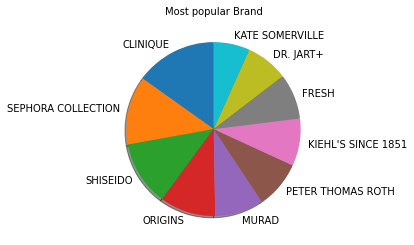

In [80]:
PopularBrand = skin['Brand'].value_counts().head(10)
plt.pie(PopularBrand, labels = PopularBrand.index, shadow=True, startangle=90)
plt.title("Most popular Brand", fontsize=10)
plt.show()

In [81]:
skin['Brand'].value_counts().head(10).to_frame()

,Brand
CLINIQUE,79
SEPHORA COLLECTION,66
SHISEIDO,63
ORIGINS,54
MURAD,47
PETER THOMAS ROTH,46
KIEHL'S SINCE 1851,46
FRESH,44
DR. JART+,41
KATE SOMERVILLE,35


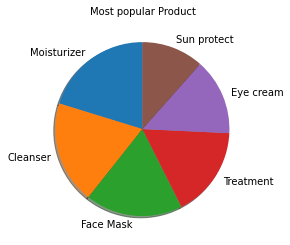

In [82]:
productype = skin['Label'].value_counts()
plt.pie(productype, labels = productype.index, shadow=True, startangle=90)
plt.title("Most popular Product", fontsize=10)
plt.show()

In [83]:
moisturizers = skin[skin["Label"]=="Moisturizer"]

moisturizersdry = moisturizers[moisturizers["Dry"]==1]

moisturizersdry =moisturizersdry.reset_index(drop=True)
moisturizers

,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,"Algae (Seaweed) Extract, Mineral Oil, Petrolat...",1,1,1,1,1
1,Moisturizer,SK-II,Facial Treatment Essence,179,4.1,"Galactomyces Ferment Filtrate (Pitera), Butyle...",1,1,1,1,1
2,Moisturizer,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68,4.4,"Water, Dicaprylyl Carbonate, Glycerin, Ceteary...",1,1,1,1,0
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175,3.8,"Algae (Seaweed) Extract, Cyclopentasiloxane, P...",1,1,1,1,1
4,Moisturizer,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,38,4.1,"Water, Snail Secretion Filtrate, Phenyl Trimet...",1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
293,Moisturizer,LA MER,The Moisturizing Matte Lotion,270,3.9,"Water, Algae (Seaweed) Extract, Propanediol, S...",0,0,1,1,0
294,Moisturizer,HERBIVORE,Jasmine Green Tea Balancing Toner,39,4.2,"Jasminum Officinale (Jasmine) Flower Water, Ha...",1,0,0,1,1
295,Moisturizer,CLARINS,Super Restorative Night Age Spot Correcting Re...,136,4.5,"Water, Cetearyl Isononanoate, Dimethicone, Gly...",0,0,0,0,0
296,Moisturizer,KATE SOMERVILLE,Goat Milk Moisturizing Cream,65,4.1,"Water, Ethylhexyl Palmitate, Myristyl Myristat...",1,1,1,1,1


In [84]:
ingredientindex = {}
corpus = []
index = 0

for i in range(len(moisturizersdry)):    
    ingredients = moisturizersdry['Ingredients'][i]
    loweringredients = ingredients.lower()
    tokens = loweringredients.split(', ')
    corpus.append(tokens)
    for ingredient in tokens:
        if ingredient not in ingredientindex:
            ingredientindex[ingredient] = index
            index += 1
            

In [85]:
M = len(moisturizersdry)
N = len(ingredientindex)

A = np.zeros([M,N])

In [86]:
def oh_encoder(tokens):
    x = np.zeros(N)
    for ingredient in tokens:
        idx = ingredientindex[ingredient]
        x[idx] = 1
    return x

In [87]:
i = 0
for tokens in corpus:
    A[i, :] = oh_encoder(tokens)
    i+=1

In [88]:
model = TSNE(n_components=2,learning_rate=200,random_state=42)
tsne_features = model.fit_transform(A)

moisturizersdry['X'] = tsne_features[:,0]
moisturizersdry['Y'] = tsne_features[:,1]

In [89]:
from bokeh.io import show, output_notebook, push_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool
output_notebook()

source = ColumnDataSource(moisturizersdry)
plot = figure(x_axis_label = "T-SNE 1", 
              y_axis_label = "T-SNE 2", 
              width = 500, height = 400)
plot.circle(x = "X", 
    y = "Y", 
    source = source, 
    size = 10, color = '#FF7373', alpha = .8)

Loading BokehJS ...

GlyphRenderer(id='1148', ...)

In [90]:
hover = HoverTool(tooltips = [('Item','@Name'),
                              ('Brand','@Brand'),
                              ('Price','$@Price'),
                              ('Rank','@Rank')])
plot.add_tools(hover)

In [91]:
show(plot)

In [92]:
cosmetic_1 = moisturizersdry[moisturizersdry['Name'] == "Color Control Cushion Compact Broad Spectrum SPF 50+"]
cosmetic_2 = moisturizersdry[moisturizersdry['Name'] == "BB Cushion Hydra Radiance SPF 50"]

display(cosmetic_1)
print(cosmetic_1.Price.values)
print(cosmetic_1.Ingredients.values)
display(cosmetic_2)
print(cosmetic_2.Price.values)
print(cosmetic_2.Ingredients.values)


,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive,X,Y
45,Moisturizer,AMOREPACIFIC,Color Control Cushion Compact Broad Spectrum S...,60,4.0,"Phyllostachis Bambusoides Juice, Cyclopentasil...",1,1,1,1,1,0.362798,-0.922107


[60]
['Phyllostachis Bambusoides Juice, Cyclopentasiloxane, Cyclohexasiloxane, Peg-10 Dimethicone, Phenyl Trimethicone, Butylene Glycol, Butylene Glycol Dicaprylate/Dicaprate, Alcohol, Arbutin, Lauryl Peg-9 Polydimethylsiloxyethyl Dimethicone, Acrylates/Ethylhexyl Acrylate/Dimethicone Methacrylate Copolymer, Polyhydroxystearic Acid, Sodium Chloride, Polymethyl Methacrylate, Aluminium Hydroxide, Stearic Acid, Disteardimonium Hectorite, Triethoxycaprylylsilane, Ethylhexyl Palmitate, Lecithin, Isostearic Acid, Isopropyl Palmitate, Phenoxyethanol, Polyglyceryl-3 Polyricinoleate, Acrylates/Stearyl Acrylate/Dimethicone Methacrylate Copolymer, Dimethicone, Disodium Edta, Trimethylsiloxysilicate, Ethylhexyglycerin, Dimethicone/Vinyl Dimethicone Crosspolymer, Water, Silica, Camellia Japonica Seed Oil, Camillia Sinensis Leaf Extract, Caprylyl Glycol, 1,2-Hexanediol, Fragrance, Titanium Dioxide, Iron Oxides (Ci 77492, Ci 77491, Ci77499).']


,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive,X,Y
55,Moisturizer,LANEIGE,BB Cushion Hydra Radiance SPF 50,38,4.3,"Water, Cyclopentasiloxane, Zinc Oxide (CI 7794...",1,1,1,1,1,0.378321,-0.963305


[38]
['Water, Cyclopentasiloxane, Zinc Oxide (CI 77947), Ethylhexyl Methoxycinnamate, PEG-10 Dimethicone, Cyclohexasiloxane, Phenyl Trimethicone, Iron Oxides (CI 77492), Butylene Glycol Dicaprylate/Dicaprate, Niacinamide, Lauryl PEG-9 Polydimethylsiloxyethyl Dimethicone, Acrylates/Ethylhexyl Acrylate/Dimethicone Methacrylate Copolymer, Titanium Dioxide (CI 77891 , Iron Oxides (CI 77491), Butylene Glycol, Sodium Chloride, Iron Oxides (CI 77499), Aluminum Hydroxide, HDI/Trimethylol Hexyllactone Crosspolymer, Stearic Acid, Methyl Methacrylate Crosspolymer, Triethoxycaprylylsilane, Phenoxyethanol, Fragrance, Disteardimonium Hectorite, Caprylyl Glycol, Yeast Extract, Acrylates/Stearyl Acrylate/Dimethicone Methacrylate Copolymer, Dimethicone, Trimethylsiloxysilicate, Polysorbate 80, Disodium EDTA, Hydrogenated Lecithin, Dimethicone/Vinyl Dimethicone Crosspolymer, Mica (CI 77019), Silica, 1,2-Hexanediol, Polypropylsilsesquioxane, Chenopodium Quinoa Seed Extract, Magnesium Sulfate, Calcium Chl

In [93]:
cosmetic = pd.read_csv(r"C:\Users\flore\Downloads\skincare_products.csv", sep=",")
cosmetic

,product_name,brand,product_url,product_type,ingredients,price
0,Acorelle Pure Harvest Body Perfume - 100ml,Acorelle,https://www.lookfantastic.com/acorelle-pure-ha...,Mist,"Alcohol, Aqua, Glycerin, Fragrance, Limonene, ...",£10.00
1,Aesop Amazing Face Cleanser 200ml,Aesop,https://www.lookfantastic.com/aesop-amazing-fa...,Cleanser,"Water, Cocamidopropyl Belaine, Sea Salt, Glyce...",£35.00
2,Aesop Animal Body Wash 500ml,Aesop,https://www.lookfantastic.com/aesop-animal-bod...,Body Wash,"Water (Aqua), Sodium Laureth Sulfate, Propylen...",£27.00
3,Aesop Chamomile Concentrate Anti-Blemish Mask ...,Aesop,https://www.lookfantastic.com/aesop-chamomile-...,Mask,"Water (Aqua), Kaolin, Bentonite, Alcohol Denat...",£31.00
4,Aesop Parsley Seed Anti-Oxidant Eye Cream 10ml,Aesop,https://www.lookfantastic.com/aesop-parsley-se...,Eye Care,"Aloe Barbadensis Leaf Juice, Water, PEG-60 Alm...",£63.00
...,...,...,...,...,...,...
1133,Zelens PROVITAMIN D Fortifying Facial Mist 50ml,Zelens,https://www.lookfantastic.com/zelens-provitami...,Mist,"Aqua (Water), Propanediol, Glycerin, Polyglyce...",£55.00
1134,Zelens Triple Action Advanced Eye Cream,Zelens,https://www.lookfantastic.com/zelens-triple-ac...,Eye Care,"Aqua (Water), Dimethicone, Cyclopentasiloxane,...",£80.00
1135,Zelens Youth Concentrate Supreme Age-Defying S...,Zelens,https://www.lookfantastic.com/zelens-youth-con...,Serum,"Water (Aqua), Caprylic/Capric Triglyceride, Hy...",£160.00
1136,Zelens Z Balance Prebiotic and Probiotic Facia...,Zelens,https://www.lookfantastic.com/zelens-z-balance...,Mist,"Aqua, Butylene Glycol, Sodium Lactate, Lactoba...",£48.00


In [94]:
cosmetic['price'] = cosmetic['price'].str.replace('£', '')
cosmetic['price'] = cosmetic['price'].astype(float)

In [95]:
contents = []    
for title in cosmetic['product_name']:
    try: 
        m = re.search('\d+(ml|g|kg)', title)
        contents.append(m.group())
    except AttributeError:
        contents.append(np.nan)

cosmetic['contents'] = contents
cosmetic

,product_name,brand,product_url,product_type,ingredients,price,contents
0,Acorelle Pure Harvest Body Perfume - 100ml,Acorelle,https://www.lookfantastic.com/acorelle-pure-ha...,Mist,"Alcohol, Aqua, Glycerin, Fragrance, Limonene, ...",10.0,100ml
1,Aesop Amazing Face Cleanser 200ml,Aesop,https://www.lookfantastic.com/aesop-amazing-fa...,Cleanser,"Water, Cocamidopropyl Belaine, Sea Salt, Glyce...",35.0,200ml
2,Aesop Animal Body Wash 500ml,Aesop,https://www.lookfantastic.com/aesop-animal-bod...,Body Wash,"Water (Aqua), Sodium Laureth Sulfate, Propylen...",27.0,500ml
3,Aesop Chamomile Concentrate Anti-Blemish Mask ...,Aesop,https://www.lookfantastic.com/aesop-chamomile-...,Mask,"Water (Aqua), Kaolin, Bentonite, Alcohol Denat...",31.0,60ml
4,Aesop Parsley Seed Anti-Oxidant Eye Cream 10ml,Aesop,https://www.lookfantastic.com/aesop-parsley-se...,Eye Care,"Aloe Barbadensis Leaf Juice, Water, PEG-60 Alm...",63.0,10ml
...,...,...,...,...,...,...,...
1133,Zelens PROVITAMIN D Fortifying Facial Mist 50ml,Zelens,https://www.lookfantastic.com/zelens-provitami...,Mist,"Aqua (Water), Propanediol, Glycerin, Polyglyce...",55.0,50ml
1134,Zelens Triple Action Advanced Eye Cream,Zelens,https://www.lookfantastic.com/zelens-triple-ac...,Eye Care,"Aqua (Water), Dimethicone, Cyclopentasiloxane,...",80.0,NaN
1135,Zelens Youth Concentrate Supreme Age-Defying S...,Zelens,https://www.lookfantastic.com/zelens-youth-con...,Serum,"Water (Aqua), Caprylic/Capric Triglyceride, Hy...",160.0,30ml
1136,Zelens Z Balance Prebiotic and Probiotic Facia...,Zelens,https://www.lookfantastic.com/zelens-z-balance...,Mist,"Aqua, Butylene Glycol, Sodium Lactate, Lactoba...",48.0,50ml


In [96]:
cosmetic['contents'].isna().sum()

155

In [97]:
cosmetic = pd.read_csv('skincare_prepared.csv', sep=",")
cosmetic

,product_name,brand,product_url,product_type,ingredients,price,contents
0,Acorelle Pure Harvest Body Perfume - 100ml,Acorelle,https://www.lookfantastic.com/acorelle-pure-ha...,Mist,"Alcohol, Aqua, Glycerin, Fragrance, Limonene, ...",10.0,100ml
1,Aesop Parsley Seed Anti-Oxidant Eye Cream 10ml,Aesop,https://www.lookfantastic.com/aesop-parsley-se...,Eye Care,"Aloe Barbadensis Leaf Juice, Water, PEG-60 Alm...",63.0,10ml
2,Aesop Parsley Seed Anti-Oxidant Eye Serum 15ml,Aesop,https://www.lookfantastic.com/aesop-parsley-se...,Eye Care,"Aloe Babedensis Lead Juice, Water (Aqua), PEG ...",57.0,15ml
3,Aesop Amazing Face Cleanser 200ml,Aesop,https://www.lookfantastic.com/aesop-amazing-fa...,Cleanser,"Water, Cocamidopropyl Belaine, Sea Salt, Glyce...",35.0,200ml
4,Aesop Animal Body Wash 500ml,Aesop,https://www.lookfantastic.com/aesop-animal-bod...,Body Wash,"Water (Aqua), Sodium Laureth Sulfate, Propylen...",27.0,500ml
...,...,...,...,...,...,...,...
1130,Zelens Triple Action Advanced Eye Cream,Zelens,https://www.lookfantastic.com/zelens-triple-ac...,Eye Care,"Aqua (Water), Dimethicone, Cyclopentasiloxane,...",80.0,15ml
1131,Zelens Youth Concentrate Supreme Age-Defying S...,Zelens,https://www.lookfantastic.com/zelens-youth-con...,Serum,"Water (Aqua), Caprylic/Capric Triglyceride, Hy...",160.0,30ml
1132,Zelens Z Hyaluron Hyaluronic Acid Complex Seru...,Zelens,https://www.lookfantastic.com/zelens-z-hyaluro...,Serum,"Aqua (Water), Glycerin, Propanediol, Hydrolyze...",55.0,30ml
1133,Zelens PROVITAMIN D Fortifying Facial Mist 50ml,Zelens,https://www.lookfantastic.com/zelens-provitami...,Mist,"Aqua (Water), Propanediol, Glycerin, Polyglyce...",55.0,50ml


In [98]:
cosmetic['contents'] = cosmetic['contents'].str.replace('ml', '')
cosmetic['contents'] = cosmetic['contents'].str.replace('g', '')
cosmetic

,product_name,brand,product_url,product_type,ingredients,price,contents
0,Acorelle Pure Harvest Body Perfume - 100ml,Acorelle,https://www.lookfantastic.com/acorelle-pure-ha...,Mist,"Alcohol, Aqua, Glycerin, Fragrance, Limonene, ...",10.0,100
1,Aesop Parsley Seed Anti-Oxidant Eye Cream 10ml,Aesop,https://www.lookfantastic.com/aesop-parsley-se...,Eye Care,"Aloe Barbadensis Leaf Juice, Water, PEG-60 Alm...",63.0,10
2,Aesop Parsley Seed Anti-Oxidant Eye Serum 15ml,Aesop,https://www.lookfantastic.com/aesop-parsley-se...,Eye Care,"Aloe Babedensis Lead Juice, Water (Aqua), PEG ...",57.0,15
3,Aesop Amazing Face Cleanser 200ml,Aesop,https://www.lookfantastic.com/aesop-amazing-fa...,Cleanser,"Water, Cocamidopropyl Belaine, Sea Salt, Glyce...",35.0,200
4,Aesop Animal Body Wash 500ml,Aesop,https://www.lookfantastic.com/aesop-animal-bod...,Body Wash,"Water (Aqua), Sodium Laureth Sulfate, Propylen...",27.0,500
...,...,...,...,...,...,...,...
1130,Zelens Triple Action Advanced Eye Cream,Zelens,https://www.lookfantastic.com/zelens-triple-ac...,Eye Care,"Aqua (Water), Dimethicone, Cyclopentasiloxane,...",80.0,15
1131,Zelens Youth Concentrate Supreme Age-Defying S...,Zelens,https://www.lookfantastic.com/zelens-youth-con...,Serum,"Water (Aqua), Caprylic/Capric Triglyceride, Hy...",160.0,30
1132,Zelens Z Hyaluron Hyaluronic Acid Complex Seru...,Zelens,https://www.lookfantastic.com/zelens-z-hyaluro...,Serum,"Aqua (Water), Glycerin, Propanediol, Hydrolyze...",55.0,30
1133,Zelens PROVITAMIN D Fortifying Facial Mist 50ml,Zelens,https://www.lookfantastic.com/zelens-provitami...,Mist,"Aqua (Water), Propanediol, Glycerin, Polyglyce...",55.0,50


In [99]:
cosmetic['contents'] = cosmetic['contents'].astype(float)
cosmetic['price'] = cosmetic['price'].astype(float)
cosmetic

,product_name,brand,product_url,product_type,ingredients,price,contents
0,Acorelle Pure Harvest Body Perfume - 100ml,Acorelle,https://www.lookfantastic.com/acorelle-pure-ha...,Mist,"Alcohol, Aqua, Glycerin, Fragrance, Limonene, ...",10.0,100.0
1,Aesop Parsley Seed Anti-Oxidant Eye Cream 10ml,Aesop,https://www.lookfantastic.com/aesop-parsley-se...,Eye Care,"Aloe Barbadensis Leaf Juice, Water, PEG-60 Alm...",63.0,10.0
2,Aesop Parsley Seed Anti-Oxidant Eye Serum 15ml,Aesop,https://www.lookfantastic.com/aesop-parsley-se...,Eye Care,"Aloe Babedensis Lead Juice, Water (Aqua), PEG ...",57.0,15.0
3,Aesop Amazing Face Cleanser 200ml,Aesop,https://www.lookfantastic.com/aesop-amazing-fa...,Cleanser,"Water, Cocamidopropyl Belaine, Sea Salt, Glyce...",35.0,200.0
4,Aesop Animal Body Wash 500ml,Aesop,https://www.lookfantastic.com/aesop-animal-bod...,Body Wash,"Water (Aqua), Sodium Laureth Sulfate, Propylen...",27.0,500.0
...,...,...,...,...,...,...,...
1130,Zelens Triple Action Advanced Eye Cream,Zelens,https://www.lookfantastic.com/zelens-triple-ac...,Eye Care,"Aqua (Water), Dimethicone, Cyclopentasiloxane,...",80.0,15.0
1131,Zelens Youth Concentrate Supreme Age-Defying S...,Zelens,https://www.lookfantastic.com/zelens-youth-con...,Serum,"Water (Aqua), Caprylic/Capric Triglyceride, Hy...",160.0,30.0
1132,Zelens Z Hyaluron Hyaluronic Acid Complex Seru...,Zelens,https://www.lookfantastic.com/zelens-z-hyaluro...,Serum,"Aqua (Water), Glycerin, Propanediol, Hydrolyze...",55.0,30.0
1133,Zelens PROVITAMIN D Fortifying Facial Mist 50ml,Zelens,https://www.lookfantastic.com/zelens-provitami...,Mist,"Aqua (Water), Propanediol, Glycerin, Polyglyce...",55.0,50.0


In [100]:
cosmetic['product_type'].unique() 

array(['Mist', 'Eye Care', 'Cleanser', 'Body Wash', 'Mask', 'Bath Salts',
       'Peel', 'Toner', 'Balm', 'Moisturiser', 'Bath Oil', 'Oil', 'Serum',
       'Exfoliator'], dtype=object)

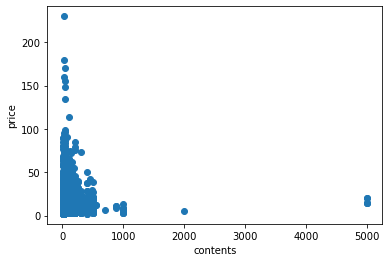

In [101]:
fig, ax = plt.subplots()
ax.scatter(cosmetic['contents'], cosmetic['price'])
ax.set_xlabel("contents")
ax.set_ylabel("price")
plt.show()

(array([412., 306., 208.,  90.,  50.,  23.,  20.,  15.,   3.,   1.,   0.,
          1.,   1.,   2.,   1.,   1.,   0.,   0.,   0.,   1.]),
 array([  1.95  ,  13.3525,  24.755 ,  36.1575,  47.56  ,  58.9625,
         70.365 ,  81.7675,  93.17  , 104.5725, 115.975 , 127.3775,
        138.78  , 150.1825, 161.585 , 172.9875, 184.39  , 195.7925,
        207.195 , 218.5975, 230.    ]),
 <BarContainer object of 20 artists>)

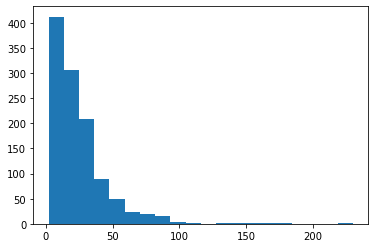

In [102]:
fig, ax = plt.subplots()
ax.hist(cosmetic['price'], bins=20)

In [103]:
print(cosmetic['price'].describe())

count    1135.000000
mean       23.963419
std        21.713618
min         1.950000
25%         9.950000
50%        18.900000
75%        31.250000
max       230.000000
Name: price, dtype: float64


In [104]:
cosmetic['price'] = cosmetic["price"].apply(lambda x: 1 if x > 18.90 else 0)

cosmetic['price'].value_counts()

0    568
1    567
Name: price, dtype: int64

#### Creating Test and Train sets

In [105]:
y = np.array(cosmetic['price'])
y.shape
y

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [106]:
X = cosmetic[['contents', 'product_type', 'ingredients']]
X


,contents,product_type,ingredients
0,100.0,Mist,"Alcohol, Aqua, Glycerin, Fragrance, Limonene, ..."
1,10.0,Eye Care,"Aloe Barbadensis Leaf Juice, Water, PEG-60 Alm..."
2,15.0,Eye Care,"Aloe Babedensis Lead Juice, Water (Aqua), PEG ..."
3,200.0,Cleanser,"Water, Cocamidopropyl Belaine, Sea Salt, Glyce..."
4,500.0,Body Wash,"Water (Aqua), Sodium Laureth Sulfate, Propylen..."
...,...,...,...
1130,15.0,Eye Care,"Aqua (Water), Dimethicone, Cyclopentasiloxane,..."
1131,30.0,Serum,"Water (Aqua), Caprylic/Capric Triglyceride, Hy..."
1132,30.0,Serum,"Aqua (Water), Glycerin, Propanediol, Hydrolyze..."
1133,50.0,Mist,"Aqua (Water), Propanediol, Glycerin, Polyglyce..."


In [107]:
Xtraining, Xtesting, ytraining, ytesting = train_test_split(X, y, 
                                                    test_size = 0.4, random_state=random_state, stratify=y)

In [108]:
Xtraining

,contents,product_type,ingredients
145,250.0,Mist,"Butane, Water, Alcohol, Isobutane, Propane, Di..."
1099,150.0,Body Wash,"Water (Aqua), Sesamum Indicum (Sesame) Seed Oi..."
168,150.0,Cleanser,"Aqua (Water), Cocamidopropyl betaine, Coco-glu..."
141,30.0,Serum,"Water\Aqua\Eau, Squalane, Glycerin, Butylene G..."
775,100.0,Exfoliator,"Water (Aqua), Ammonium Lauryl Sulfate, Cocamid..."
...,...,...,...
591,15.0,Eye Care,"Aqua / Water, Glycerin, Carbomer, Glycinesoja ..."
723,460.0,Bath Salts,"Himalayan Salts, Geranium, Sweet Blood Orange,..."
791,200.0,Toner,"Aqua (Water), Alcohol Denat., Aloe Barbadensis..."
208,14.0,Eye Care,"Purified Water, Niacinamide, Cetyl Alcohol, Ca..."


In [109]:
def tokenizer(x) -> list: 
    x = x.replace('(', '')
    x = x.replace(')', '')
    x = x.replace("\xa0", " ")
    x = x.replace(".", ",")
    x = x.replace(" & ", ", ")
    x = re.split(', ', x)

    return x

In [110]:
ohe = OneHotEncoder()
vect = CountVectorizer(tokenizer=lambda x: tokenizer(x))
scaler = StandardScaler()

### LOGISTIC REGRESSION without brand name

In [111]:
columnT = make_column_transformer(
    (ohe, ["product_type"]),
    (vect, "ingredients"),
    (scaler, ["contents"]), 
    remainder="passthrough")


In [112]:
log = LogisticRegression(random_state=random_state, max_iter = 10000)
logPipe = make_pipeline(columnT, log)

In [113]:
logPipe.fit(Xtraining, ytraining)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['product_type']),
                                                 ('countvectorizer',
                                                  CountVectorizer(tokenizer=<function <lambda> at 0x000001BFDC8523A0>),
                                                  'ingredients'),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['contents'])])),
                ('logisticregression',
                 LogisticRegression(max_iter=10000, random_state=1))])

In [114]:
logPipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('onehotencoder', OneHotEncoder(),
                                    ['product_type']),
                                   ('countvectorizer',
                                    CountVectorizer(tokenizer=<function <lambda> at 0x000001BFDC8523A0>),
                                    'ingredients'),
                                   ('standardscaler', StandardScaler(),
                                    ['contents'])])),
  ('logisticregression', LogisticRegression(max_iter=10000, random_state=1))],
 'verbose': False,
 'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('onehotencoder', OneHotEncoder(),
                                  ['product_type']),
                                 ('countvectorizer',
                                  CountVectorizer(tokenizer=<function <lambda> at 0x000001BFDC8523A0>),

In [115]:
logisticPredictions = logPipe.predict(Xtesting)
logisticPredictions

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,

In [116]:
accuracy_score(ytesting, logisticPredictions)

0.762114537444934

In [117]:
print(classification_report(ytesting, logisticPredictions))

              precision    recall  f1-score   support

           0       0.73      0.82      0.78       227
           1       0.80      0.70      0.75       227

    accuracy                           0.76       454
   macro avg       0.77      0.76      0.76       454
weighted avg       0.77      0.76      0.76       454



In [118]:
confusion_matrix(ytesting, logisticPredictions)

array([[187,  40],
       [ 68, 159]], dtype=int64)

In [119]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
tols = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
Cs = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]


param_grid = {'logisticregression__C': Cs, 'logisticregression__solver':solvers, 'logisticregression__tol':tols}
logPipe = make_pipeline(columnT, log)
lrGs = RandomizedSearchCV(estimator=logPipe, param_distributions=param_grid, random_state=random_state, scoring='accuracy', cv=10, refit=True)
lrGs = lrGs.fit(Xtraining, ytraining)
lrGs.best_params_

{'logisticregression__tol': 1e-05,
 'logisticregression__solver': 'saga',
 'logisticregression__C': 10}

In [120]:
bestRegression = lrGs.best_estimator_ 
bestRegression.score(Xtesting, ytesting)

0.73568281938326

In [121]:
score = cross_val_score(estimator=bestRegression, X =Xtraining, y=ytraining, cv=10, n_jobs=1)
print(score)
print('Accuracy = {:.8f} +/- {:.8f}'.format(np.mean(score), np.std(score)))

[0.79710145 0.72058824 0.63235294 0.75       0.77941176 0.67647059
 0.82352941 0.75       0.69117647 0.67647059]
Accuracy = 0.72971014 +/- 0.05775174


### DECISION TREE with out Brand

In [122]:
from sklearn.tree import DecisionTreeClassifier

decisionTree = DecisionTreeClassifier(random_state=random_state, criterion='entropy')
columnT = make_column_transformer(
    (ohe, ["product_type"]),
    (vect, "ingredients"), 
    remainder="passthrough")
treepipe = make_pipeline(columnT, decisionTree)

treepipe.fit(Xtraining,ytraining)
treepredictions = treepipe.predict(Xtesting)
accuracy_score(ytesting, treepredictions)

0.6519823788546255

In [123]:
treepipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('onehotencoder', OneHotEncoder(),
                                    ['product_type']),
                                   ('countvectorizer',
                                    CountVectorizer(tokenizer=<function <lambda> at 0x000001BFDC8523A0>),
                                    'ingredients')])),
  ('decisiontreeclassifier',
   DecisionTreeClassifier(criterion='entropy', random_state=1))],
 'verbose': False,
 'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('onehotencoder', OneHotEncoder(),
                                  ['product_type']),
                                 ('countvectorizer',
                                  CountVectorizer(tokenizer=<function <lambda> at 0x000001BFDC8523A0>),
                                  'ingredients')]),
 'decisiontreeclassifier': DecisionTreeClassifier(crit

In [124]:
print(classification_report(ytesting, treepredictions))

              precision    recall  f1-score   support

           0       0.67      0.61      0.64       227
           1       0.64      0.69      0.67       227

    accuracy                           0.65       454
   macro avg       0.65      0.65      0.65       454
weighted avg       0.65      0.65      0.65       454



In [125]:
confusion_matrix(ytesting, treepredictions)

array([[139,  88],
       [ 70, 157]], dtype=int64)

In [126]:
scores = cross_val_score(estimator=treepipe, X=Xtraining, y=ytraining, cv=10, n_jobs=1)
print(scores)

[0.72463768 0.61764706 0.52941176 0.67647059 0.64705882 0.70588235
 0.75       0.63235294 0.64705882 0.66176471]


In [127]:
print('Accuracy = {:.8f} +/- {:.8f}'.format(np.mean(scores), np.std(scores)))

Accuracy = 0.65922847 +/- 0.05882009


In [128]:
criterions = ['gini', 'entropy']
max_depths = [None, 10, 100, 1000, 10000]
param_grid = {'decisiontreeclassifier__min_samples_leaf': np.arange(1,50), 
              'decisiontreeclassifier__max_depth': max_depths, 
              'decisiontreeclassifier__criterion':criterions}

dtgs = RandomizedSearchCV(estimator=treepipe, param_distributions=param_grid, random_state=random_state, scoring='accuracy', cv=10, refit=True)
dtgs = dtgs.fit(Xtraining, ytraining)
print(dtgs.best_params_)
besttree = dtgs.best_estimator_ 
print(besttree.score(Xtesting, ytesting))

{'decisiontreeclassifier__min_samples_leaf': 31, 'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__criterion': 'entropy'}
0.7070484581497798


In [129]:
scores = cross_val_score(estimator=besttree, X=Xtraining, y=ytraining, cv=10, n_jobs=1)
print(scores)

[0.75362319 0.67647059 0.72058824 0.76470588 0.69117647 0.69117647
 0.80882353 0.76470588 0.64705882 0.61764706]


In [130]:
print('Accuracy = {:.8f} +/- {:.8f}'.format(np.mean(scores), np.std(scores)))

Accuracy = 0.71359761 +/- 0.05653384


### RANDOM FOREST without Brand

In [131]:
from sklearn.ensemble import RandomForestClassifier

In [132]:
randomForest = RandomForestClassifier(n_estimators = 1000, random_state = random_state)

randompipe = make_pipeline(columnT, randomForest)
randompipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('onehotencoder', OneHotEncoder(),
                                    ['product_type']),
                                   ('countvectorizer',
                                    CountVectorizer(tokenizer=<function <lambda> at 0x000001BFDC8523A0>),
                                    'ingredients')])),
  ('randomforestclassifier',
   RandomForestClassifier(n_estimators=1000, random_state=1))],
 'verbose': False,
 'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('onehotencoder', OneHotEncoder(),
                                  ['product_type']),
                                 ('countvectorizer',
                                  CountVectorizer(tokenizer=<function <lambda> at 0x000001BFDC8523A0>),
                                  'ingredients')]),
 'randomforestclassifier': RandomForestClassifier(n_esti

In [133]:
randompipe.fit(Xtraining, ytraining)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['product_type']),
                                                 ('countvectorizer',
                                                  CountVectorizer(tokenizer=<function <lambda> at 0x000001BFDC8523A0>),
                                                  'ingredients')])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=1000, random_state=1))])

In [134]:
randompred = randompipe.predict(Xtesting)

In [135]:
accuracy_score(ytesting, randompred)

0.7599118942731278

In [136]:
criterions = ['gini', 'entropy']
max_depths = [None, 10, 100, 1000, 10000]
param_grid = {'randomforestclassifier__min_samples_leaf': np.arange(1,50), 
              'randomforestclassifier__max_depth': max_depths, 
              'randomforestclassifier__criterion':criterions}

randomForest = RandomForestClassifier(n_estimators = 1000, random_state = random_state)
randompipe = make_pipeline(columnT, randomForest)

rfgs = RandomizedSearchCV(estimator=randompipe, param_distributions=param_grid, random_state=random_state, scoring='accuracy', cv=10, refit=True)
rfgs = rfgs.fit(Xtraining, ytraining)
print(rfgs.best_params_)
bestforest = rfgs.best_estimator_
print(bestforest.score(Xtesting, ytesting))

{'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_depth': 10000, 'randomforestclassifier__criterion': 'gini'}
0.748898678414097


In [137]:
scores = cross_val_score(estimator=bestforest, X=Xtraining, y=ytraining, cv=10, n_jobs=1)
print(scores)
print('Accuracy = {:.8f} +/- {:.8f}'.format(np.mean(scores), np.std(scores)))

[0.82608696 0.72058824 0.66176471 0.82352941 0.76470588 0.77941176
 0.83823529 0.76470588 0.79411765 0.75      ]
Accuracy = 0.77231458 +/- 0.05088843


### SUPPORT VECTOR MACHINE without Brand

In [138]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', random_state = random_state)

In [139]:
columnT = make_column_transformer(
    (ohe, ["product_type"]),
    (vect, "ingredients"),
    (scaler, ["contents"]),
    remainder="passthrough")

In [140]:
svmPipe = make_pipeline(columnT, svm)
svmPipe.fit(Xtraining, ytraining)
svmPredictions = svmPipe.predict(Xtesting)
accuracy_score(ytesting, svmPredictions)

0.7070484581497798

In [141]:
print(classification_report(ytesting, svmPredictions))

              precision    recall  f1-score   support

           0       0.69      0.77      0.72       227
           1       0.73      0.65      0.69       227

    accuracy                           0.71       454
   macro avg       0.71      0.71      0.71       454
weighted avg       0.71      0.71      0.71       454



In [142]:
confusion_matrix(ytesting, svmPredictions)

array([[174,  53],
       [ 80, 147]], dtype=int64)

In [143]:
svm = SVC(kernel='linear', random_state = random_state)
columnT = make_column_transformer(
    (ohe, ["product_type"]),
    (vect, "ingredients"),
    (scaler, ["contents"]), 
    remainder="passthrough")
svmPipe = make_pipeline(columnT, svm)

param_grid = [{'svc__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
               'svc__kernel': ['linear']},
              {'svc__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
               'svc__gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
               'svc__kernel': ['rbf']}]

svmgs = RandomizedSearchCV(estimator=svmPipe, random_state = random_state, param_distributions=param_grid, scoring='accuracy', cv=10, refit=True)
svmgs = svmgs.fit(Xtraining, ytraining)
print(svmgs.best_params_)
bestsvm = svmgs.best_estimator_ 
print(bestsvm.score(Xtesting,ytesting))

{'svc__kernel': 'rbf', 'svc__gamma': 0.0001, 'svc__C': 100}
0.7202643171806168


In [144]:
scores = cross_val_score(estimator=bestsvm, X=Xtraining, y=ytraining, cv=10, n_jobs=1)
print(scores)
print('Accuracy = {:.8f} +/- {:.8f}'.format(np.mean(scores), np.std(scores)))

[0.79710145 0.67647059 0.66176471 0.70588235 0.76470588 0.70588235
 0.85294118 0.72058824 0.73529412 0.75      ]
Accuracy = 0.73706309 +/- 0.05433613


### K- NEAREST NEIGHBOUR without brand

In [145]:
from sklearn.neighbors import KNeighborsClassifier as KNN
knn = KNN(n_neighbors=5)

In [146]:
knnPipe = make_pipeline(columnT, knn)
knnPipe.fit(Xtraining, ytraining)
knnPredictions = knnPipe.predict(Xtesting)
accuracy_score(ytesting, knnPredictions)

0.6255506607929515

In [147]:
knnPipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('onehotencoder', OneHotEncoder(),
                                    ['product_type']),
                                   ('countvectorizer',
                                    CountVectorizer(tokenizer=<function <lambda> at 0x000001BFDC8523A0>),
                                    'ingredients'),
                                   ('standardscaler', StandardScaler(),
                                    ['contents'])])),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('onehotencoder', OneHotEncoder(),
                                  ['product_type']),
                                 ('countvectorizer',
                                  CountVectorizer(tokenizer=<function <lambda> at 0x000001BFDC8523A0>),
                         

In [148]:
print(classification_report(ytesting, knnPredictions))

              precision    recall  f1-score   support

           0       0.61      0.72      0.66       227
           1       0.66      0.53      0.59       227

    accuracy                           0.63       454
   macro avg       0.63      0.63      0.62       454
weighted avg       0.63      0.63      0.62       454



In [149]:
knnPipe = make_pipeline(columnT, knn)
param_grid = {'kneighborsclassifier__n_neighbors': np.arange(1,50), 
              'kneighborsclassifier__weights':['uniform', 'distance']}

knngs = RandomizedSearchCV(estimator=knnPipe, param_distributions=param_grid, random_state=random_state, scoring='accuracy', cv=10, refit=True)
knngs = knngs.fit(Xtraining, ytraining)
print(knngs.best_params_)
bestknn = knngs.best_estimator_
print(bestknn.score(Xtesting,ytesting))

{'kneighborsclassifier__weights': 'distance', 'kneighborsclassifier__n_neighbors': 9}
0.6145374449339207


In [150]:
scores = cross_val_score(estimator=bestknn, X=Xtraining, y=ytraining, cv=10, n_jobs=1)
print(scores)
print('Accuracy = {:.8f} +/- {:.8f}'.format(np.mean(scores), np.std(scores)))

[0.66666667 0.66176471 0.60294118 0.58823529 0.66176471 0.70588235
 0.55882353 0.51470588 0.54411765 0.66176471]
Accuracy = 0.61666667 +/- 0.06046723
